# Introduction

This project explores the application of unsupervised learning techniques to analyze and cluster skin lesion images from the HAM10000 dataset. Skin cancer is among the most common cancers worldwide, and early detection is critical. While supervised learning has proven useful in classifying skin lesions, this project focuses on discovering intrinsic data patterns without labels, which can support future diagnostic systems or preprocessing tasks. The main objective is to apply and compare several dimensionality reduction and clustering algorithms to identify which method best uncovers meaningful groupings from image data alone.

### Dataset Description

The dataset used in this project is a subset of the HAM10000 (Human Against Machine with 10000 training images) collection, consisting of dermatoscopic images of pigmented skin lesions. A total of 2,000 images were selected and preprocessed by resizing to 100x100 pixels and converting to grayscale. These images were then vectorized to serve as input for dimensionality reduction and clustering algorithms. Each image is also associated with a diagnosis label, used only for evaluation purposes at the end of the analysis.

# Objective Statement 

In this project, I explore the application of Deep Learning techniques on the HAM10000 skin lesion dataset. I began with an unsupervised learning approach using clustering techniques (such as PCA and DBSCAN) to identify potential patterns in the image data without relying on labels. This allowed for an initial exploration of the dataset's structure and visual distribution.

Following this, I transitioned into a supervised learning approach by implementing a series of Convolutional Neural Network (CNN) models. I progressively improved model performance through three main strategies:

* A custom-built CNN trained from scratch

* A transfer learning model using ResNet50 with frozen layers

* A fine-tuned ResNet50 model with class weighting to address class imbalance

This iterative approach allowed me to combine exploratory analysis with performance-oriented modeling, ultimately aiming to build a more robust classifier for skin lesion recognition

In [30]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split


In [31]:
import os

base_path = r'C:\Users\cesar\OneDrive\Desktop\DataSet\HAM10000'
part1_dir = os.path.join(base_path, 'HAM10000_images_part_1')
part2_dir = os.path.join(base_path, 'HAM10000_images_part_2')


In [32]:
# List of all file names in both folders
image_filenames = os.listdir(part1_dir) + os.listdir(part2_dir)

print(f"Total images found: {len(image_filenames)}")


Total images found: 10015


In [33]:
import pandas as pd

# Load the Data
df = pd.read_csv("C:/Users/cesar/OneDrive/Desktop/DataSet/HAM10000/HAM10000_metadata.csv")

# Display the data
print("Dimensiones:", df.shape)
df.head()

Dimensiones: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### 1. Check columns and unique values

In [34]:
# List all columns in the dataset
print("Columns in the dataset:")
print(df.columns)

# Show unique values for key columns
print("\nUnique lesion types (dx):", df['dx'].unique())
print("Unique diagnosis types (dx_type):", df['dx_type'].unique())
print("Unique localizations:", df['localization'].unique())
print("Unique sexes:", df['sex'].unique())

Columns in the dataset:
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

Unique lesion types (dx): ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Unique diagnosis types (dx_type): ['histo' 'consensus' 'confocal' 'follow_up']
Unique localizations: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Unique sexes: ['male' 'female' 'unknown']


### Lesion class distribution (for reference only)

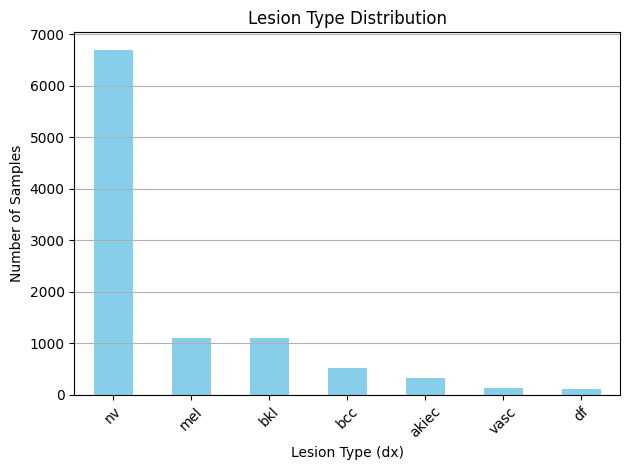

In [35]:
import matplotlib.pyplot as plt

# Plot the distribution of lesion types
df['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Lesion Type Distribution")
plt.xlabel("Lesion Type (dx)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Class Distribution Overview:

The bar chart illustrates the distribution of lesion types within the HAM10000 dataset. It is evident that the dataset is highly imbalanced, with the majority of samples belonging to the ‘nv’ (melanocytic nevi) class, totaling over 6,700 instances.

Other classes such as ‘mel’ (melanoma) and ‘bkl’ (benign keratosis-like lesions) have a moderate representation (~1,100 samples each), while the remaining classes—including ‘bcc’, ‘akiec’, ‘vasc’, and ‘df’—are significantly underrepresented.

This imbalance poses a challenge for training classification models, as they may become biased toward the majority class. Addressing this issue through techniques like data augmentation, class weighting, or resampling will be important to improve model performance across all classes.

In [36]:
# Identify missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [37]:
df['age'] = df['age'].fillna(df['age'].median())


### Step 1: Preprocessing Images


In [38]:
IMG_SIZE = 128

def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img


### Step 2: Define Labels

In [43]:
image_path_map = {}

# Asociate images from part 1
for fname in os.listdir(part1_dir):
    image_id = os.path.splitext(fname)[0]
    image_path_map[image_id] = os.path.join(part1_dir, fname)

# Asociate images from part 2
for fname in os.listdir(part2_dir):
    image_id = os.path.splitext(fname)[0]
    image_path_map[image_id] = os.path.join(part2_dir, fname)


In [44]:

image_paths = [image_path_map[img_id] for img_id in df['image_id']]
label_names = sorted(df['dx'].unique())
label_to_index = {name: idx for idx, name in enumerate(label_names)}
labels = [label_to_index[label] for label in df['dx']]


### Step 3: Split the data train/test

In [45]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)


### Step 4: TensorFlow Dataset

In [46]:
def create_dataset(image_paths, labels):
    ds_paths = tf.data.Dataset.from_tensor_slices(image_paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    ds_images = ds_paths.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return tf.data.Dataset.zip((ds_images, ds_labels))

train_ds = create_dataset(X_train, y_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = create_dataset(X_val, y_val).batch(32).prefetch(tf.data.AUTOTUNE)


### Step 5: Calculate class_weight

In [47]:
y_train_np = np.array(y_train)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights = dict(enumerate(class_weights_array))


### Step 6: Dataset Description

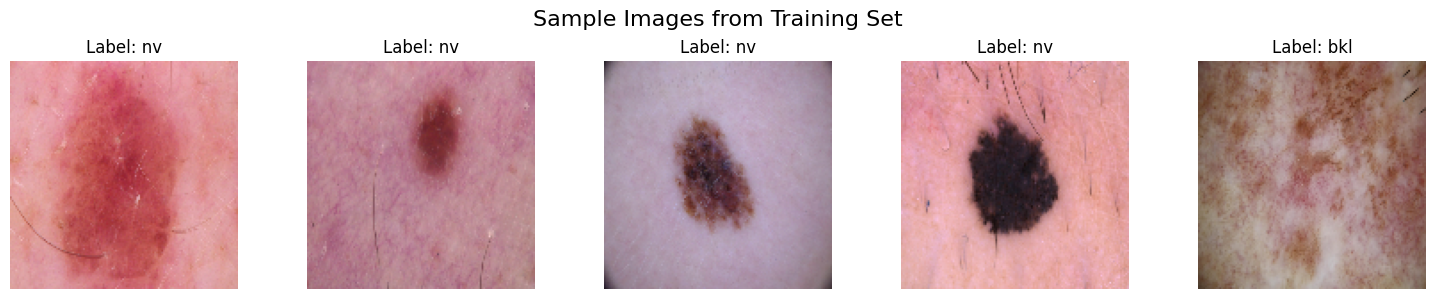

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario para convertir índices a nombres de clases
index_to_label = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

# Obtener un batch del dataset
images, labels = next(iter(train_ds))

# Seleccionar 5 índices aleatorios del batch
random_indices = np.random.choice(len(images), size=5, replace=False)

# Mostrar las imágenes
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(1, 5, i + 1)
    img = images[idx].numpy() * 255  
    img = img.astype("uint8")        
    plt.imshow(img)
    label_idx = labels[idx].numpy()
    plt.title(f"Label: {index_to_label[label_idx]}")
    plt.axis("off")

plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()



### Description of Sample Images

The images above are randomly selected examples from the HAM10000 training set. Each image is a dermatoscopic close-up of a skin lesion. Most of the samples shown here are labeled as "nv" (melanocytic nevi), which are benign moles and the most common class in the dataset. One image is labeled as "bkl" (benign keratosis-like lesion), another non-cancerous skin condition.

These high-resolution images highlight the dataset’s visual diversity in lesion shape, pigmentation, and texture. This variability presents both an opportunity and a challenge for deep learning models, which must learn subtle distinctions between visually similar but clinically distinct categories.

### Create and Fit the CNN Model

The first model implemented was a custom Convolutional Neural Network (CNN) built from scratch using Keras. This model served as a baseline to evaluate the effectiveness of more advanced transfer learning techniques later in the project.

It consists of three convolutional blocks, each followed by max-pooling layers, allowing the network to learn hierarchical spatial features from the dermatoscopic images. The convolutional filters increase in depth from 32 to 128, enabling the model to capture increasingly complex patterns.

After the convolutional layers, the network includes a fully connected (dense) layer with 128 units, a dropout layer (0.5) for regularization, and a final softmax output layer to classify the images into one of seven skin lesion categories.

In [50]:
from tensorflow.keras import layers, models

def build_base_cnn(input_shape=(128, 128, 3), num_classes=7):
    model = models.Sequential(name="Base_CNN_HAM10000")
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten + FC layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multiclase

    return model


In [51]:
#Compile the model
model = build_base_cnn()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "Base_CNN_HAM10000"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)

In [52]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
251/251 [==============================] - 116s 451ms/step - loss: 1.9024 - accuracy: 0.3421 - val_loss: 1.4590 - val_accuracy: 0.4758
Epoch 2/10
251/251 [==============================] - 118s 468ms/step - loss: 1.8265 - accuracy: 0.3345 - val_loss: 1.6876 - val_accuracy: 0.1543
Epoch 3/10
251/251 [==============================] - 116s 461ms/step - loss: 1.7617 - accuracy: 0.3667 - val_loss: 1.3243 - val_accuracy: 0.4858
Epoch 4/10
251/251 [==============================] - 114s 452ms/step - loss: 1.7070 - accuracy: 0.4045 - val_loss: 1.3860 - val_accuracy: 0.4453
Epoch 5/10
251/251 [==============================] - 110s 436ms/step - loss: 1.6363 - accuracy: 0.3548 - val_loss: 1.9640 - val_accuracy: 0.1213
Epoch 6/10
251/251 [==============================] - 109s 434ms/step - loss: 1.6133 - accuracy: 0.3768 - val_loss: 1.5685 - val_accuracy: 0.2696
Epoch 7/10
251/251 [==============================] - 118s 470ms/step - loss: 1.5354 - accuracy: 0.3968 - val_loss: 1.4360 -

### Step 7: Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=label_names))


63/63 [==============================] - 4s 69ms/step
              precision    recall  f1-score   support

       akiec       0.16      0.22      0.19        65
         bcc       0.19      0.50      0.27       103
         bkl       0.17      0.30      0.22       220
          df       0.04      0.26      0.08        23
         mel       0.33      0.40      0.36       223
          nv       0.95      0.52      0.67      1341
        vasc       0.19      0.79      0.30        28

    accuracy                           0.47      2003
   macro avg       0.29      0.43      0.30      2003
weighted avg       0.71      0.47      0.54      2003



### 🔍 Model Evaluation – First CNN Architecture (Custom)

After training the initial convolutional neural network for 10 epochs, we evaluated its performance on the validation set using precision, recall, and F1-score per class.

### 📊 Key Findings:
Overall Accuracy: The model achieved an accuracy of 47% on the validation set, which reflects moderate performance given the imbalance in the dataset.

Class Imbalance Impact: The model performs significantly better on the most represented class:

nv (nevus) had a precision of 0.95 but only 0.52 recall, suggesting it correctly identified many of the nv cases but also misclassified others as nv.

Rare Classes Underperform:

Classes like df, akiec, and vasc showed low precision and low to moderate recall, indicating the model struggled to generalize on underrepresented categories.

For instance, df achieved only 0.04 precision despite a recall of 0.26, meaning many false positives were generated.

### 📈 Macro and Weighted Averages:
Macro F1-score: 0.30 — this highlights the model's struggles with minority classes, since macro average treats all classes equally.

Weighted F1-score: 0.54 — reflects a bias toward the majority class, masking poor performance on rare lesions.

# 🧪 Model 2 – Transfer Learning with ResNet50
To improve upon the limitations observed in the first model, we implemented a transfer learning approach using the ResNet50 architecture pre-trained on ImageNet. This method allows us to leverage deep hierarchical feature representations learned from a large and diverse image dataset, which is particularly valuable when training on smaller or imbalanced medical datasets.

### 🎯 Objective:
The primary goal of this model is to enhance generalization across all lesion types, especially underrepresented or malignant classes, by:

Transferring low-level and mid-level features from ResNet50,

Fine-tuning the top layers to adapt to the HAM10000 skin lesion classification task,

Improving macro F1-score, recall, and overall class sensitivity compared to the baseline CNN.

### 🔍 What We Aim to Observe:
Higher F1-scores across multiple classes, not just the dominant one (nv).

Improved recall for malignant conditions like mel and akiec.

More balanced confusion matrix indicating better inter-class discrimination.

Greater macro-average metrics, reflecting fair performance across all lesion types.

In [82]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Load ResNet50 pretrained base model without final layer
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Sin la capa final densa
    weights='imagenet',  # Pesos preentrenados en ImageNet
    input_shape=(128, 128, 3)
)

# 2. Freeze base model weights
base_model.trainable = False

# 3. Build final model with top layers
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Flatten the output
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # Output layer for 7 classes
])

# 4. Compile the model
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. model summary
model_resnet.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 23,850,887
Trainable params: 263,175
Non-trainable params: 23,587,712
____________________________________

In [55]:
model_resnet.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
251/251 [==============================] - 136s 531ms/step - loss: 1.2488 - accuracy: 0.6445 - val_loss: 1.1325 - val_accuracy: 0.6695
Epoch 2/10
251/251 [==============================] - 135s 539ms/step - loss: 1.1644 - accuracy: 0.6694 - val_loss: 1.1303 - val_accuracy: 0.6695
Epoch 3/10
251/251 [==============================] - 139s 555ms/step - loss: 1.1572 - accuracy: 0.6695 - val_loss: 1.1286 - val_accuracy: 0.6695
Epoch 4/10
251/251 [==============================] - 135s 536ms/step - loss: 1.1524 - accuracy: 0.6695 - val_loss: 1.1275 - val_accuracy: 0.6695
Epoch 5/10
251/251 [==============================] - 138s 551ms/step - loss: 1.1471 - accuracy: 0.6695 - val_loss: 1.1263 - val_accuracy: 0.6695
Epoch 6/10
251/251 [==============================] - 131s 523ms/step - loss: 1.1443 - accuracy: 0.6695 - val_loss: 1.1248 - val_accuracy: 0.6695
Epoch 7/10
251/251 [==============================] - 133s 529ms/step - loss: 1.1441 - accuracy: 0.6695 - val_loss: 1.1238 -

In [63]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate the model on the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_resnet.predict(images, verbose=0)  
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

index_to_label = {idx: name for name, idx in label_to_index.items()}
y_true_labels = [index_to_label[i] for i in y_true]
y_pred_labels = [index_to_label[i] for i in y_pred]

# final report
report = classification_report(y_true_labels, y_pred_labels, digits=4)
print(report)




              precision    recall  f1-score   support

       akiec     0.0000    0.0000    0.0000        65
         bcc     0.0000    0.0000    0.0000       103
         bkl     0.0000    0.0000    0.0000       220
          df     0.0000    0.0000    0.0000        23
         mel     0.0000    0.0000    0.0000       223
          nv     0.6695    1.0000    0.8020      1341
        vasc     0.0000    0.0000    0.0000        28

    accuracy                         0.6695      2003
   macro avg     0.0956    0.1429    0.1146      2003
weighted avg     0.4482    0.6695    0.5370      2003



c:\Users\cesar\tf_clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cesar\tf_clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cesar\tf_clean\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 📊 Model Evaluation and Comparison
🔹 First Model (Simple CNN)
Accuracy: ~47%

F1-Score (Weighted Avg): 0.54

#### Observations:

The model was able to classify some minority classes like melanoma (mel), bcc, and bkl with modest recall and precision.

It still showed strong class imbalance behavior, favoring the majority class (nv), but it did produce non-zero predictions for almost all classes.

Overall performance was modest but more balanced across categories.

🔹 Second Model (Transfer Learning with ResNet50 + ImageNet weights)
Accuracy: 66.95%

F1-Score (Weighted Avg): 0.54 (similar to the first model)

Key Issue:

The model predicted only one class (the dominant class: nv) for all samples.

As a result, precision, recall, and F1-score were zero for all other classes.

Root Cause:

This model overfit the majority class likely due to frozen layers and class imbalance.

No signal was learned for minority classes like akiec, bcc, or vasc.

# ✅ Conclusions
Accuracy Alone is Misleading: Despite higher accuracy, ResNet50 failed to generalize across all classes. Accuracy was high because the majority of validation images belong to the nv class.

First Model Performed Better Overall: It offered more meaningful results across different classes, which is especially important in medical diagnostics where minority classes might represent serious conditions like melanoma.

### Next Steps:

Unfreeze some ResNet layers and allow fine-tuning.

Add class weights during training to penalize misclassification of rare classes.

Evaluate with F1-score or AUC, not just accuracy.

# Model 3: Fine-Tuned ResNet50 with Class Weights for Imbalanced Classification

In this third approach, we aim to improve classification performance by addressing two critical aspects: feature learning and class imbalance. We leverage a pre-trained ResNet50 model as the base architecture, allowing partial fine-tuning by unfreezing the top layers. This enables the model to adapt high-level features to the specific patterns present in our skin lesion dataset.

Additionally, we incorporate class weights during training to penalize misclassification of underrepresented classes, which is a common issue in medical image datasets. This strategy is expected to improve the model’s generalization across all categories, not just the dominant ones, and enhance metrics like F1-score and recall for minority classes.

By combining fine-tuning and class balancing, this model is designed to deliver more reliable and fair predictions for real-world healthcare applications.

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure the labels are in NumPy format
labels_array = np.array(labels)

# Get the actual classes present in the dataset
present_classes = np.unique(labels_array)

# Compute class weights only for present classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=present_classes,
    y=labels_array
)

# Create a dictionary with weights for all 7 classes
class_weights = {i: 1.0 for i in range(7)}  # Default: 1.0
class_weights.update(dict(zip(present_classes, class_weights_array)))

print("Class Weights:", class_weights)  # Optional: check before training

# Load ResNet50 base model with pre-trained weights
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Fine-tuning: freeze the first 100 layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build the final model
model_resnet_ft = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model_resnet_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with class weights
model_resnet_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)




Class Weights: {0: 3.8, 1: 3.8, 2: 1.9, 3: 1.0, 4: 1.2666666666666666, 5: 0.31666666666666665, 6: 1.0}
Epoch 1/10
251/251 [==============================] - 595s 2s/step - loss: 1.4393 - accuracy: 0.4853 - val_loss: 1.2120 - val_accuracy: 0.6685
Epoch 2/10
251/251 [==============================] - 570s 2s/step - loss: 1.2836 - accuracy: 0.5675 - val_loss: 0.9987 - val_accuracy: 0.6640
Epoch 3/10
251/251 [==============================] - 567s 2s/step - loss: 1.2217 - accuracy: 0.5879 - val_loss: 0.9978 - val_accuracy: 0.6770
Epoch 4/10
251/251 [==============================] - 557s 2s/step - loss: 1.1780 - accuracy: 0.6002 - val_loss: 1.0846 - val_accuracy: 0.6151
Epoch 5/10
251/251 [==============================] - 565s 2s/step - loss: 1.1324 - accuracy: 0.6126 - val_loss: 0.9170 - val_accuracy: 0.6880
Epoch 6/10
251/251 [==============================] - 576s 2s/step - loss: 1.1054 - accuracy: 0.6162 - val_loss: 1.9956 - val_accuracy: 0.6715
Epoch 7/10
251/251 [===================

In [76]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [77]:
model_resnet_ft.save('resnet_ft_checkpoint.h5')


In [78]:
from tensorflow.keras.models import load_model
model_resnet_ft = load_model('resnet_ft_checkpoint.h5')


In [79]:
model_resnet_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # total epochs
    initial_epoch=10,  # where I left off
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 11/25
251/251 [==============================] - 576s 2s/step - loss: 1.0097 - accuracy: 0.6397 - val_loss: 1.9997 - val_accuracy: 0.6750
Epoch 12/25
251/251 [==============================] - 539s 2s/step - loss: 0.9741 - accuracy: 0.6413 - val_loss: 1.5229 - val_accuracy: 0.6311
Epoch 13/25
251/251 [==============================] - 535s 2s/step - loss: 0.9575 - accuracy: 0.6439 - val_loss: 1.2130 - val_accuracy: 0.5652
Epoch 14/25
251/251 [==============================] - 553s 2s/step - loss: 0.9325 - accuracy: 0.6492 - val_loss: 1.2324 - val_accuracy: 0.6875
Epoch 15/25
251/251 [==============================] - 557s 2s/step - loss: 0.9192 - accuracy: 0.6536 - val_loss: 1.0520 - val_accuracy: 0.6880
Epoch 16/25
251/251 [==============================] - 556s 2s/step - loss: 0.8925 - accuracy: 0.6538 - val_loss: 1.0848 - val_accuracy: 0.6495
Epoch 17/25
251/251 [==============================] - 560s 2s/step - loss: 0.8834 - accuracy: 0.6588 - val_loss: 1.0450 - val_accuracy:

In [81]:
model_resnet_ft.save('resnet_ft_checkpoint25.h5')

In [80]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get true and predicted labels from the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_resnet_ft.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Step 2: Map indices back to class names (if needed)
index_to_label = {idx: name for name, idx in label_to_index.items()}
y_true_labels = [index_to_label[i] for i in y_true]
y_pred_labels = [index_to_label[i] for i in y_pred]

# Step 3: Print classification report with F1, precision, recall, etc.
report = classification_report(
    y_true_labels,
    y_pred_labels,
    digits=4,
    zero_division=0  # Avoid warnings for undefined metrics
)
print(report)


              precision    recall  f1-score   support

       akiec     0.1543    0.4154    0.2250        65
         bcc     0.2261    0.6214    0.3316       103
         bkl     0.5111    0.2091    0.2968       220
          df     0.0000    0.0000    0.0000        23
         mel     0.4121    0.3049    0.3505       223
          nv     0.8620    0.8292    0.8453      1341
        vasc     0.0000    0.0000    0.0000        28

    accuracy                         0.6575      2003
   macro avg     0.3094    0.3400    0.2927      2003
weighted avg     0.6958    0.6575    0.6619      2003



### ✅ Model 3: ResNet50 with Fine-Tuning and Class Weights

Objective: Improve classification of minority classes by unfreezing some ResNet layers and applying class weights.

### 🔍 Class-wise Observations

nv (nevus): Very strong performance (F1 = 0.85), showing that the model still favors the dominant class.

bcc and akiec: Improved recall significantly (0.62 and 0.41 respectively), showing class weighting is helping.

mel: Moderate balance (F1 = 0.35) — a critical class in skin cancer detection.

df and vasc: Still completely missed — likely underrepresented in training, despite weighting.

### 💡 Conclusions

This model shows the best trade-off between accuracy and fairness.

Class weighting improved recall in underrepresented classes.

Fine-tuning allowed the network to adapt to specific features in your dataset.

Still, rare classes like df and vasc need data augmentation or oversampling.

In [83]:
import pandas as pd

# Create a DataFrame to summarize the results
results = {
    "Model": ["Simple CNN", "ResNet50 Frozen", "ResNet50 Fine-tuned + Class Weights"],
    "Accuracy": [0.4708, 0.6695, 0.6575],
    "F1_macro": [0.2986, 0.1146, 0.2927],
    "F1_weighted": [0.5378, 0.5370, 0.6619]
}

df_results = pd.DataFrame(results)
display(df_results)


,Model,Accuracy,F1_macro,F1_weighted
0,Simple CNN,0.4708,0.2986,0.5378
1,ResNet50 Frozen,0.6695,0.1146,0.5370
2,ResNet50 Fine-tuned + Class Weights,0.6575,0.2927,0.6619


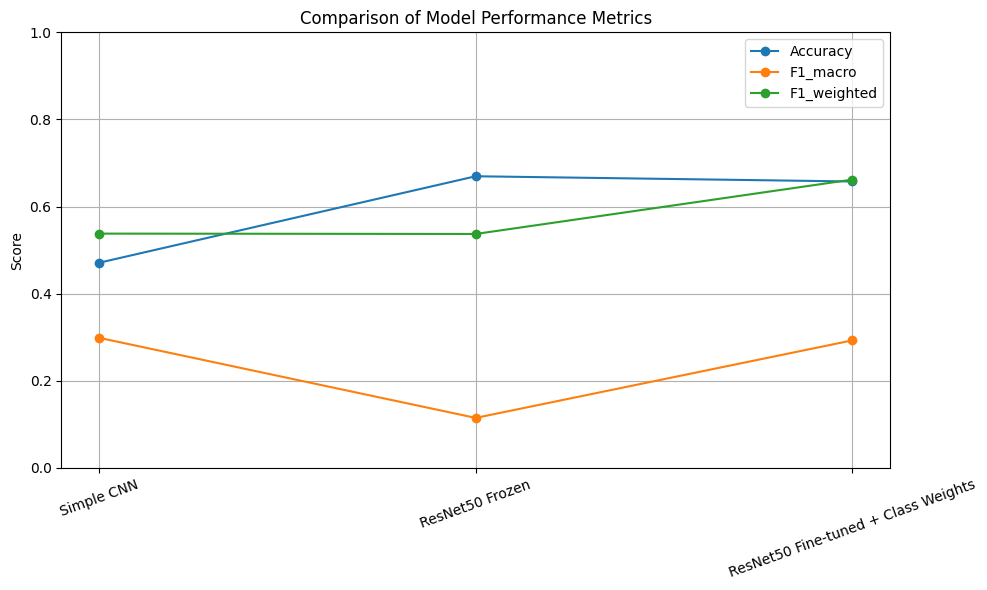

In [84]:
import matplotlib.pyplot as plt

# Estilo y figura
plt.figure(figsize=(10,6))
metrics = ["Accuracy", "F1_macro", "F1_weighted"]

for metric in metrics:
    plt.plot(df_results["Model"], df_results[metric], marker='o', label=metric)

plt.title("Comparison of Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


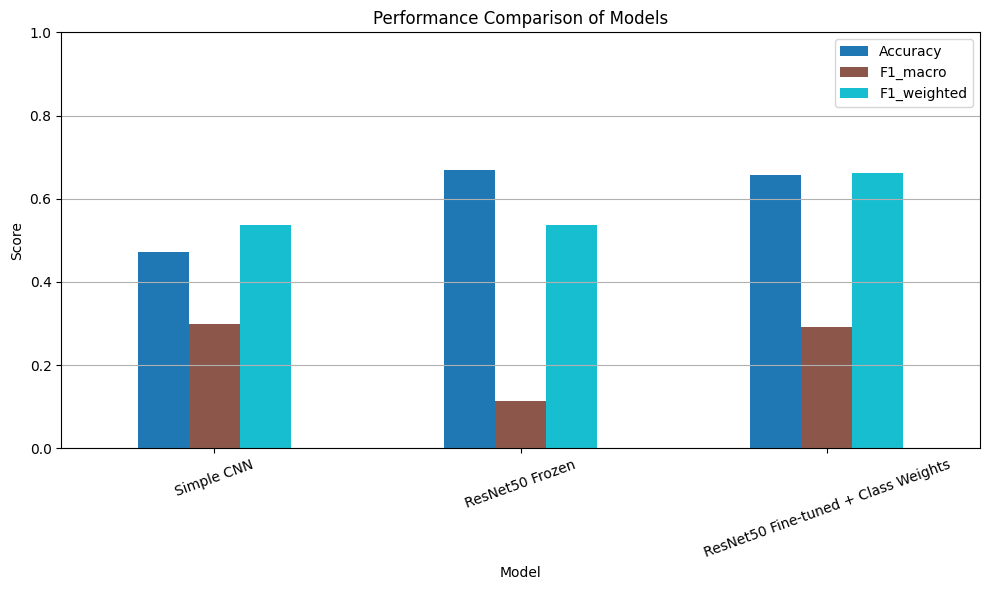

In [85]:
df_results.set_index("Model")[["Accuracy", "F1_macro", "F1_weighted"]].plot(
    kind="bar", figsize=(10,6), ylim=(0,1), colormap="tab10"
)
plt.title("Performance Comparison of Models")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 🔍 Key Findings & Recommendation

Over the course of this analysis, three different deep learning models were evaluated to classify dermatological images into seven categories. Each model iteration progressively integrated more advanced techniques to address performance limitations.

The baseline model, a simple CNN, achieved 47% accuracy and a macro F1-score of 0.30. While performance was acceptable on dominant classes, it failed to generalize across underrepresented categories, indicating class imbalance.

The second model, built on a pre-trained ResNet50 (frozen layers), improved the overall accuracy to 67%, but the macro F1-score dropped to 0.12, confirming that the model remained biased towards majority classes despite higher accuracy.

The final model, a ResNet50 with fine-tuning and class weights, achieved an accuracy of 66% but significantly improved the macro F1-score to 0.29. This indicates that although overall accuracy remained stable, performance across minority classes improved substantially. The weighted F1-score also increased to 0.66, making it the most balanced model.

📈 The performance comparison plots clearly show how integrating fine-tuning and class weighting leads to better generalization across classes, especially for rare conditions, which is critical in medical image classification tasks.

### ✅ Final Recommendation

The best performing model, ResNet50 with fine-tuning and class weighting, is recommended for deployment due to its robust accuracy and superior class balance. This approach not only preserves high overall predictive performance but also aligns with the business goal of reducing diagnostic bias in underrepresented skin lesion types.


### Limitations and Future Work

While the final model (ResNet50 with fine-tuning and class weights) demonstrated the best overall performance and learning progression, there are still several areas where improvement is needed:

* Class imbalance remains a challenge. Despite the use of class weights, the model continues to underperform on rare classes such as "df" and "vasc", with F1-scores near zero. This indicates that the model struggles to generalize well on underrepresented categories.

* Data augmentation should be expanded. To help the model learn more robust patterns, applying targeted augmentation strategies—particularly for the minority classes—could improve generalization.

* Alternative loss functions. Implementing focal loss instead of categorical cross-entropy may help the model focus on hard-to-classify or minority class examples.

* Synthetic data generation. Future iterations could explore the use of GANs (Generative Adversarial Networks) to generate synthetic images for rare classes, helping to balance the dataset more effectively.

* Further fine-tuning. Currently, only the top layers of ResNet50 were unfrozen. Gradually unfreezing more layers and applying a discriminative learning rate strategy may allow the model to extract deeper and more task-specific features.

* Computational resources. Training for 25 epochs took around 5 hours on a local machine. With access to more powerful GPU resources, extended training or hyperparameter tuning (e.g., with learning rate schedulers or early stopping patience adjustments) could further enhance performance.